In [ ]:
%%writefile escritura_paralela.c
#include "mpi.h"
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define BLOCK_LOW(id,p,n)  ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n) (BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)
#define BLOCK_OWNER(j,p,n) (((p)*((j)+1)-1)/(n))
//  ■■■■■■■■■■■■■■■■■
int main( int argc, char *argv[] ){
    int i, size, n, rank, count, n_local;
    int *buffer;
    MPI_File fh;
    MPI_Comm comm;
    MPI_Status status;
    MPI_Offset *offset;

    MPI_Init( &argc, &argv );

    comm = MPI_COMM_WORLD;
    MPI_Comm_size( comm, &size );
    MPI_Comm_rank( comm, &rank );

    n = atoi(argv[1]) ;

    n_local = BLOCK_SIZE( rank, size, n );
    printf("\n %d) n=%d n_local = %d\n",rank, n, n_local);

    srand(rank + time(0));
    buffer = (int*)malloc(n_local*sizeof(int)); 
    if(buffer==NULL){ 
      printf("\n ERROR: No hay memoria suficiente (buffer)"); 
      MPI_Finalize(); return 1; 
      }
    for(i=0;i<n_local;i++) 
        buffer[i] = rand()%100;

    offset = (MPI_Offset*)malloc(size*sizeof(MPI_Offset));if(offset==NULL){ 
      printf("\n ERROR: No hay memoria suficiente (offset)"); 
      MPI_Finalize(); return 1; 
      }

    offset[0] = sizeof(int);
    for(i=1;i<size;i++)
        offset[i] = offset[i-1] + BLOCK_SIZE( i-1, size, n )*sizeof(int);
 
    MPI_File_open( comm, argv[2] ,MPI_MODE_WRONLY | MPI_MODE_CREATE, MPI_INFO_NULL, &fh);
        if(rank==0) MPI_File_write(fh, &n, 1, MPI_INT, MPI_STATUS_IGNORE); 
       MPI_File_write_at(fh, offset[rank], buffer, n_local, MPI_INT, &status);
    MPI_File_close( &fh );


    for(i=0;i<n_local;i++)
    printf("[%d]%d\t ", rank,buffer[i]);
    printf("\n");    

    MPI_Finalize();
    return 0;
}

Overwriting escritura_paralela.c


In [ ]:
%%script bash
mpicc escritura_paralela.c -o escritura_paralela
echo "Generar Arhivo de Datos"
for i in $(seq 1 16)
do
    echo " ----- Usando $i procesos"
    mpiexec --allow-run-as-root -np $i escritura_paralela 100 bin_datos_100.dat
done

Generar Arhivo de Datos
 ----- Usando 1 procesos

 0) n=100 n_local = 100
[0]41	 [0]6	 [0]77	 [0]7	 [0]8	 [0]96	 [0]78	 [0]80	 [0]65	 [0]74	 [0]92	 [0]46	 [0]21	 [0]39	 [0]76	 [0]9	 [0]91	 [0]49	 [0]60	 [0]65	 [0]57	 [0]98	 [0]52	 [0]19	 [0]46	 [0]0	 [0]73	 [0]74	 [0]53	 [0]82	 [0]68	 [0]95	 [0]40	 [0]45	 [0]54	 [0]48	 [0]41	 [0]33	 [0]81	 [0]58	 [0]59	 [0]73	 [0]5	 [0]81	 [0]64	 [0]33	 [0]42	 [0]56	 [0]83	 [0]2	 [0]73	 [0]92	 [0]52	 [0]77	 [0]11	 [0]98	 [0]77	 [0]36	 [0]24	 [0]31	 [0]70	 [0]92	 [0]78	 [0]11	 [0]89	 [0]32	 [0]11	 [0]83	 [0]17	 [0]92	 [0]41	 [0]77	 [0]17	 [0]98	 [0]10	 [0]82	 [0]32	 [0]52	 [0]38	 [0]67	 [0]6	 [0]63	 [0]59	 [0]58	 [0]40	 [0]23	 [0]8	 [0]17	 [0]59	 [0]32	 [0]48	 [0]82	 [0]76	 [0]78	 [0]93	 [0]65	 [0]63	 [0]56	 [0]0	 [0]80	 
 ----- Usando 2 procesos

 0) n=100 n_local = 50

 1) n=100 n_local = 50
[0]41	 [0]6	 [0]77	 [0]7	 [0]8	 [0]96	 [0]78	 [0]80	 [0]65	 [0]74	 [0]92	 [0]46	 [0]21	 [0]39	 [0]76	 [0]9	 [0]91	 [0]49	 [0]60	 [0]65	 [0]57	 [0]98	 [0]52	 [0]19

In [ ]:
%%writefile Merge_Split_ES.c
#include <stdlib.h>
#include "mpi.h"
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX 

#define BLOCK_LOW(id,p,n)  ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n) (BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)
#define BLOCK_OWNER(j,p,n) (((p)*((j)+1)-1)/(n))

void mezcla(int* S_i, int chunksize2){
    
    int *aux = NULL;
    // Pedimos memoria al arreglo auxilar
    aux = (int*) malloc(chunksize2*sizeof(int));
    
    if(aux == NULL){
      printf("No hay memoria\n");   
      MPI_Abort(MPI_COMM_WORLD,99);  
      }
  
    // Hacemos la copia del arreglo
    for (int i=0; i<chunksize2/2;i++){
      aux[i]=S_i[i];
    }

    int a = 0; // Indice que recorre la primera parte del arreglo
    int b = chunksize2 /2; // Indice que recorre la segunda parte del arreglo
    int i=0;

    // Mientras algun índice no llegue a la parte final que recorren

    while (a < chunksize2/2 && b < chunksize2){
        if(aux[a] <= S_i[b]){
            S_i[i] = aux[a];
            a++;
        }else{
            S_i[i] = S_i[b];
            b++;
        }
        i++;
    }
    // Si el indice b llegó al final de su arreglo

    if(b == chunksize2){
        // Asignamos los numeros restantes
        while(i < chunksize2){
            S_i[i] = aux[a];
            a++;
            i++;
        }
    }
    free(aux);
}

int compare(const void *_a, const void *_b){
  int *a, *b;
  a = (int *) _a;
  b = (int *) _b;
  return (*a - *b);
}

/*int read_array(char* fname, int **arr, int np) {
  FILE *myFile;
  unsigned int i, n, chunksize, faltantes;

  myFile = fopen(fname, "r");
  if(!myFile){
    printf("ERROR: No se pudo abrir el archivo para lectura %s",fname);
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  fscanf(myFile, "%i\n", &n); // numero de datos a leer

  chunksize = ceil(n*1.0 / np);
  faltantes = np*chunksize - n;

  *arr = (int *) malloc((chunksize*np)*sizeof(int));
  if (*arr == NULL) {
    printf("Memoria insuficiente\n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  for ( i=0; i < n; i++)
    fscanf(myFile, "%i\n", (*arr)+i);

  for ( i=n; i < n + faltantes; i++) //<--- Dummys
    (*arr)[i] = INT_MAX;

  return n;
}*/

int main(int argc, char**argv) {
  int rank, np, root;
  unsigned int n, chunksize, chunk, i;
  double start, tiempo;
  int *S_i;
  int dummys = 0, total_dummys = 0;
  MPI_Offset  *offset, *offset2;
  MPI_Status  status;
  MPI_File fh,fh2;


  MPI_Init(&argc, &argv);

  MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
  MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Valor de nuestro identificador

  MPI_Barrier(MPI_COMM_WORLD);  // sincronización
  start = MPI_Wtime();

  // Root es el último
  root = np - 1;

  offset = (MPI_Offset*)malloc(np*sizeof(MPI_Offset));
  if(offset==NULL){ 
    printf("\n ERROR: No hay memoria suficiente (offset)"); 
    MPI_Abort(MPI_COMM_WORLD, 99); 
    }
  MPI_File_open( MPI_COMM_WORLD, argv[1], MPI_MODE_RDONLY, MPI_INFO_NULL  , &fh );
  MPI_File_read(fh, &n, 1, MPI_INT, &status);

  offset[0] = sizeof(int);
  for( i = 1 ; i < np ; i++ ) 
  offset[i] = offset[i-1] + BLOCK_SIZE( i-1, np, n )*sizeof(int);

  chunksize = BLOCK_SIZE( rank, np, n );
  chunk = ceil(n*1.0 / np);

  S_i = (int*)malloc(2*chunk*sizeof(int));
  if( S_i == NULL ){
     printf("\n ERROR: No hay memoria suficiente (buffer)"); 
     MPI_Abort(MPI_COMM_WORLD, 99); 
  }
    
  MPI_File_read_at(fh, offset[rank], S_i, chunksize, MPI_INT, &status);        
  MPI_File_close(&fh); 

/*  // <--- toma de tiempo 1
  if (rank == root){ // Lee los datos del archivo
    n = read_array(argv[1], &Arreglo, np);
    chunksize = ceil(n*1.0 / np);
    faltantes = np*chunksize - n;

    printf("\nArreglo = {");
    for(i=0;i<n;i++)
      printf("%d, ", Arreglo[i]);
    printf("}");
  }

 // Comunica longitud de los chunks
  MPI_Bcast(&chunksize, 1, MPI_UNSIGNED, root, MPI_COMM_WORLD);
  
  // Pide memoria del doble de dicha longitud para poder ordenar
  S_i = (int *) malloc(2*chunksize*sizeof(int));
  if (S_i == NULL) {
    printf("Memoria insuficiente\n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  MPI_Scatter(Arreglo, chunksize, MPI_INT, S_i, chunksize, MPI_INT, root, MPI_COMM_WORLD);

  if (rank==0) {
    for(i=0;i<chunksize;i++)
      printf("%d\t ", S_i[i]);
  }
*/
  // ------aqui va el procesamiento a realizar con los datos

  qsort(  S_i, chunksize,sizeof(int), &compare );
  //printf("[%d]chunksize:%d\n",rank,chunksize);

  if (chunksize < chunk) {
        S_i[chunksize] = INT_MAX;
        dummys++;
        chunksize++;
    }

  for(i=1;i<=ceil(np/2.0);i++){
    if(rank%2==1) {
         MPI_Send( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD );
         MPI_Recv( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );
    }

    if(rank%2==0 && rank!=np-1){
      MPI_Recv( S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );   
      mezcla(S_i, 2*chunksize); // <---- 
      MPI_Send(S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD);  
    }

    if(rank%2==0 && rank!=0) {
         MPI_Send( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD );
         MPI_Recv( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );
    }

    if(rank%2==1 && rank!=np-1){
      MPI_Recv( S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );   
      mezcla(S_i, 2*chunksize); // <---- 
      MPI_Send(S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD);  
    }
  }

  MPI_Reduce(&dummys, &total_dummys, 1, MPI_INT, MPI_SUM, root, MPI_COMM_WORLD); 

  if ( rank == root){
      chunksize-=total_dummys;
  }

  offset2 = (MPI_Offset*)malloc(np*sizeof(MPI_Offset));
  if(offset==NULL){
     printf("\n ERROR: No hay memoria suficiente (offset)");
     MPI_Finalize();
     return 1;
   }
  offset2[0] = sizeof(int);
    for(i=1;i<np;i++){
        offset2[i] = offset2[i-1] + ceil(n*1.0 / np)*sizeof(int);
    }

  MPI_File_open( MPI_COMM_WORLD, argv[2] ,MPI_MODE_WRONLY | MPI_MODE_CREATE, MPI_INFO_NULL, &fh2);
      if(rank==0) MPI_File_write(fh2, &n, 1, MPI_INT, MPI_STATUS_IGNORE); 
    MPI_File_write_at(fh2, offset2[rank], S_i, chunksize, MPI_INT, &status);
  MPI_File_close( &fh2 );

 /* // Recolectar de nuevo los datos en el root e imprimir
  MPI_Gather(S_i, chunksize, MPI_INT, Arreglo, chunksize, MPI_INT, root, MPI_COMM_WORLD );
  // <--- toma de tiempo 2

  if( rank==root ){
    printf("\nArreglo ordenado = {");
    for(i=0;i<n;i++)
      printf("%d\t",Arreglo[i]);
    printf("}");
  }*/

  tiempo = MPI_Wtime() - start;

  free(S_i);
  free(offset);
  free(offset2);
  //if (rank == root) free(Arreglo);
  if(rank==root)
    printf("\n%d\t %.10f \n",np, tiempo);
  MPI_Finalize();
  return 0;
}

Overwriting Merge_Split_ES.c


In [ ]:
%%script bash
mpicc Merge_Split_ES.c -o Merge_Split_ES -lm
echo "Ordenamiento Rapido en Paralelo ES"
for i in $(seq 1 16)
do
    echo " ----- Usando $i procesos"
    mpiexec --allow-run-as-root -np $i Merge_Split_ES bin_datos_100.dat datos_ordenados.dat    
done

Ordenamiento Rapido en Paralelo ES
 ----- Usando 1 procesos

1	 0.0019958440 
 ----- Usando 2 procesos

2	 0.0038091730 
 ----- Usando 3 procesos

3	 0.0420670000 
 ----- Usando 4 procesos

4	 0.0774839220 
 ----- Usando 5 procesos

5	 0.1036514440 
 ----- Usando 6 procesos

6	 0.1311027280 
 ----- Usando 7 procesos

7	 0.1755837620 
 ----- Usando 8 procesos

8	 0.2869433200 
 ----- Usando 9 procesos

9	 0.2412605910 
 ----- Usando 10 procesos

10	 0.2574435880 
 ----- Usando 11 procesos

11	 0.2781627700 
 ----- Usando 12 procesos

12	 0.3778602890 
 ----- Usando 13 procesos

13	 0.2913459020 
 ----- Usando 14 procesos

14	 0.3877597660 
 ----- Usando 15 procesos

15	 0.5182123930 
 ----- Usando 16 procesos

16	 0.3889632300 


In [ ]:
%%writefile Revisar_datos.c
#include <stdlib.h>
#include "mpi.h"
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX 

#define BLOCK_LOW(id,p,n)  ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n) (BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)
#define BLOCK_OWNER(j,p,n) (((p)*((j)+1)-1)/(n))

int main(int argc, char**argv) {
    int rank, np, root;
    unsigned int n, chunksize, i, chunk;
    double start, tiempo;
    int *S_i;
    MPI_Offset  *offset;
    MPI_Status  status;
    MPI_File fh;


    MPI_Init(&argc, &argv);

    MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
    MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Valor de nuestro identificador

    MPI_Barrier(MPI_COMM_WORLD);  // sincronización

    // Root es el último
    root = np - 1;

    offset = (MPI_Offset*)malloc(np*sizeof(MPI_Offset));
    if(offset==NULL){ 
      printf("\n ERROR: No hay memoria suficiente (offset)"); 
      MPI_Abort(MPI_COMM_WORLD, 99); 
    }
    MPI_File_open( MPI_COMM_WORLD, argv[1], MPI_MODE_RDONLY, MPI_INFO_NULL  , &fh );
    MPI_File_read(fh, &n, 1, MPI_INT, &status);

    offset[0] = sizeof(int);
    for( i = 1 ; i < np ; i++ ) 
        offset[i] = offset[i-1] + BLOCK_SIZE( i-1, np, n )*sizeof(int);

    chunksize = BLOCK_SIZE( rank, np, n );


   S_i = (int*)malloc(chunksize*sizeof(int)); 
   if( S_i == NULL ){ 
     printf("\n ERROR: No hay memoria suficiente (buffer)"); 
     MPI_Abort(MPI_COMM_WORLD, 99); 
     }
    
    MPI_File_read_at(fh, offset[rank], S_i, chunksize, MPI_INT, &status);        
    MPI_File_close(&fh);
    for (i = 0; i < chunksize;i++){
        printf("[%d]%d\t",rank,S_i[i]);
    }
    printf("\n");

    MPI_Finalize();
    return 0;  
}

Writing Revisar_datos.c


In [ ]:
%%script bash
mpicc Revisar_datos.c -o Revisar_datos -lm
echo "Revisar Datos"
for i in $(seq 1 16)
do
    echo " ----- Usando $i procesos"
    mpiexec --allow-run-as-root -np $i Revisar_datos bin_datos_100.dat    
done

Revisar Datos
 ----- Usando 1 procesos
[0]95	[0]25	[0]36	[0]35	[0]32	[0]36	[0]51	[0]20	[0]58	[0]88	[0]30	[0]50	[0]26	[0]61	[0]2	[0]50	[0]87	[0]2	[0]0	[0]89	[0]44	[0]53	[0]41	[0]49	[0]82	[0]13	[0]29	[0]74	[0]60	[0]91	[0]35	[0]56	[0]52	[0]5	[0]55	[0]60	[0]67	[0]23	[0]70	[0]91	[0]3	[0]22	[0]1	[0]27	[0]16	[0]50	[0]77	[0]92	[0]44	[0]17	[0]71	[0]60	[0]10	[0]28	[0]37	[0]65	[0]54	[0]13	[0]17	[0]33	[0]19	[0]16	[0]18	[0]30	[0]96	[0]5	[0]84	[0]44	[0]75	[0]69	[0]11	[0]85	[0]84	[0]9	[0]96	[0]58	[0]27	[0]2	[0]47	[0]14	[0]18	[0]54	[0]14	[0]11	[0]22	[0]51	[0]49	[0]76	[0]18	[0]63	[0]82	[0]57	[0]55	[0]42	[0]6	[0]98	[0]8	[0]78	[0]56	[0]31	
 ----- Usando 2 procesos
[0]95	[0]25	[0]36	[0]35	[0]32	[0]36	[0]51	[0]20	[0]58	[0]88	[0]30	[0]50	[0]26	[0]61	[0]2	[0]50	[0]87	[0]2	[0]0	[0]89	[0]44	[0]53	[0]41	[0]49	[0]82	[0]13	[0]29	[0]74	[0]60	[0]91	[0]35	[0]56	[0]52	[0]5	[0]55	[0]60	[0]67	[0]23	[0]70	[0]91	[0]3	[0]22	[0]1	[0]27	[0]16	[0]50	[0]77	[0]92	[0]44	[0]17	
[1]71	[1]60	[1]10	[1]28	[1]37	[1]65	[1]54	[1]13	[1]

In [ ]:
%%writefile Muestreo_Regular_ES.c
#include <stdlib.h>
#include "mpi.h"
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX 

#define BLOCK_LOW(id,p,n)  ((id)*(n)/(p))
#define BLOCK_HIGH(id,p,n) (BLOCK_LOW((id)+1,p,n)-1)
#define BLOCK_SIZE(id,p,n) (BLOCK_HIGH(id,p,n)-BLOCK_LOW(id,p,n)+1)
#define BLOCK_OWNER(j,p,n) (((p)*((j)+1)-1)/(n))


void mezcla(int* v1, int n1,int *v2, int n2){
    int *aux = NULL;
    // Pedimos memoria al arreglo auxilar
    int ntotal = n1 + n2;
    int i;
    aux = (int*) malloc(ntotal*sizeof(int));
    if(aux == NULL){
        printf("No hay memoria\n");
        MPI_Abort(MPI_COMM_WORLD,99);
    }

    for (i = 0; i < n1; i++){
        aux[i] = v1[i];
    }


    int a = 0; // Indice que recorre la primera parte del arreglo
    int b = 0; // Indice que recorre la segunda parte del arreglo
    i=0;

    // Mientras algun índice no llegue a la parte final que recorren
    while (a < n1 && b < n2){
        if(aux[a] <= v2[b]){
            v1[i] = aux[a];
            a++;
        }else{
            v1[i] = v2[b];
            b++;
        }
        i++;
    }
    // Si el indice b llegó al final de su arreglo
    if(b == n2){
        // Asignamos los numeros restantes
        while (i < ntotal){
            v1[i] = aux[a];
            a++;
            i++;
        }
    }
    free(aux);
}

int compare(const void *_a, const void *_b) { 
  int *a, *b;
  
  a = (int *) _a;
  b = (int *) _b;
  return (*a - *b);
}

//  ■■■■
int main(int argc, char**argv) {
    int rank, np, root, faltantes;
    unsigned int n, n_r, chunksize, i,j;
    double start, tiempo;
    int *S_i;
    MPI_Offset  *offset,*offset2;
    MPI_Status  status;
    MPI_File fh,fh2;
    int *muestras;
    int *todas_las_muestras, *pivotes,*recvbuf_mezclas;
    unsigned int  *sendcounts,*recvcounts,*sdispls,*rdispls, ndatos_recv;



    MPI_Init(&argc, &argv);

    MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
    MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Valor de nuestro identificador

    MPI_Barrier(MPI_COMM_WORLD);  // sincronización
    start = MPI_Wtime();

    // Root es el último
    root = np - 1;

    offset = (MPI_Offset*)malloc(np*sizeof(MPI_Offset));if(offset==NULL){ printf("\n ERROR: No hay memoria suficiente (offset)"); MPI_Abort(MPI_COMM_WORLD, 99); }
    MPI_File_open( MPI_COMM_WORLD, argv[1], MPI_MODE_RDONLY, MPI_INFO_NULL  , &fh );
        MPI_File_read(fh, &n, 1, MPI_INT, &status);

        offset[0] = sizeof(int);
        for( i = 1 ; i < np ; i++ ) 
            offset[i] = offset[i-1] + BLOCK_SIZE( i-1, np, n )*sizeof(int);

        chunksize = BLOCK_SIZE( rank, np, n );

        S_i = (int*)malloc(chunksize*sizeof(int)); if( S_i == NULL ){ printf("\n ERROR: No hay memoria suficiente (buffer)"); MPI_Abort(MPI_COMM_WORLD, 99); }
        
        MPI_File_read_at(fh, offset[rank], S_i, chunksize, MPI_INT, &status);        
    MPI_File_close(&fh);   
     
    // ------aqui va el procesamiento a realizar con los datos

  // Cada proceso ordena localmente sus datos con QuickSort  <-----  (2)
  qsort(S_i, chunksize, sizeof(int), &compare);

  // Cada proceso selecciona los n índices 0, n/p^2, 2n/p^2, 3n/p^2,..., (p-1)n/p^2 como muestras regulares <-----  (3)
  muestras = (int*)malloc(np*sizeof(int));
  if (muestras == NULL) {printf("Memoria insuficiente (muestras)\n");MPI_Abort(MPI_COMM_WORLD, 99);}

  for(i=0;i<np;i++)
    muestras[i] = S_i[ i*n/(np*np) ];


  if(rank==root){
    todas_las_muestras = (int*)malloc(   np*np*sizeof(int) );
    if (todas_las_muestras == NULL) {printf("Memoria insuficiente (todas_las_muestras)\n");MPI_Abort(MPI_COMM_WORLD, 99);}
  }

    MPI_Gather( muestras, np, MPI_INT, todas_las_muestras, np, MPI_INT, root, MPI_COMM_WORLD );

    if(rank==root){
    qsort( todas_las_muestras, np*np, sizeof(int), &compare );
 }

  pivotes = (int*)malloc( (np-1)*sizeof(int)   );
  if (pivotes == NULL) {printf("Memoria insuficiente (pivotes) \n");MPI_Abort(MPI_COMM_WORLD, 99);}

  if(rank==root){
    for(i=0;i<np-1;i++)
      pivotes[i] = todas_las_muestras[ (i+1)*np + np/2 -1 ];    
  }

    MPI_Bcast(pivotes, np-1, MPI_INT, root, MPI_COMM_WORLD);

    // Cada proceso particiona su sublista ordenada en p piezas disjuntas, usando los valores pivote como separadores. <----- (5)

    sendcounts = (int*)malloc(np*sizeof(int));
  if (sendcounts == NULL) {printf("Memoria insuficiente (sendcounts) \n");MPI_Abort(MPI_COMM_WORLD, 99);}
  j=0; 
  for(i=0;i<(np-1);i++){
    sendcounts[i]=0;
    while(S_i[j]<=pivotes[i] && j<chunksize ){
      sendcounts[i]++;
      j++;
    }
  }
  sendcounts[np-1]=0;
  while( j < chunksize ){
    sendcounts[np-1]++;
    j++;
  }
  sdispls = (int*)malloc( np*sizeof(int) );
  if (sdispls == NULL) {printf("Memoria insuficiente (sdispls) \n");MPI_Abort(MPI_COMM_WORLD, 99);}

  sdispls[0]=0;
  for(i=1;i<np;i++)
    sdispls[i] = sdispls[i-1]+sendcounts[i-1];

  recvcounts =  (int*)malloc( np*sizeof(int) );
  if (recvcounts == NULL) {printf("Memoria insuficiente (recvcounts) \n");MPI_Abort(MPI_COMM_WORLD, 99);}

  MPI_Alltoall( sendcounts, 1, MPI_INT, recvcounts, 1, MPI_INT, MPI_COMM_WORLD );

  rdispls = (int*)malloc( np*sizeof(int) );
  if (rdispls == NULL) {printf("Memoria insuficiente (rdispls) \n");MPI_Abort(MPI_COMM_WORLD, 99);}

  rdispls[0]=0;
  for(i=1;i<np;i++)
    rdispls[i] = rdispls[i-1]+recvcounts[i-1];
  
  ndatos_recv =0;
  for(i=0;i<np;i++)
    ndatos_recv += recvcounts[i];
  
  recvbuf_mezclas = (int*)malloc( ndatos_recv *sizeof(int) );
  if (recvbuf_mezclas == NULL) {printf("Memoria insuficiente (recvbuf_mezclas) \n");MPI_Abort(MPI_COMM_WORLD, 99);}

  // Cada proceso Pi mantiene su iesima partición y envía la j-partición al proceso Pj (alltoallv)  <----- (6) 
  MPI_Alltoallv( S_i, sendcounts, sdispls, MPI_INT, recvbuf_mezclas, recvcounts, rdispls, MPI_INT, MPI_COMM_WORLD );

  // Cada proceso mezcla sus p particiones para obtener una sola lista.  <----- (7)

  n_r = recvcounts[0];
  for (i = 1; i < np; i++) {
      mezcla(recvbuf_mezclas,n_r,recvbuf_mezclas + rdispls[i],recvcounts[i]);
      n_r += recvcounts[i];
  }



  // Recolectar los elementos que tiene cada proceso en un solo proceso con fines de impresión <---- (8)

  MPI_Gather(&ndatos_recv, 1, MPI_INT, recvcounts, 1,MPI_INT,root, MPI_COMM_WORLD);
  if(rank==root){
      
    rdispls[0]=0;
    for(i=1;i<np;i++)  
      rdispls[i]= rdispls[i-1] + recvcounts[i-1];
  }

  offset2 = (MPI_Offset*)malloc(np*sizeof(MPI_Offset));if(offset==NULL){ printf("\n ERROR: No hay memoria suficiente (offset)"); MPI_Finalize(); return 1; }
  MPI_Bcast(rdispls, np, MPI_INT, root, MPI_COMM_WORLD);

  for(i=0;i<np;i++){
      offset2[i] = (rdispls[i] + 1)*sizeof(int);
  }

  MPI_File_open( MPI_COMM_WORLD, argv[2] ,MPI_MODE_WRONLY | MPI_MODE_CREATE, MPI_INFO_NULL, &fh2);
        if(rank==0) MPI_File_write(fh2, &n, 1, MPI_INT, MPI_STATUS_IGNORE); 
      MPI_File_write_at(fh2, offset2[rank], recvbuf_mezclas, ndatos_recv, MPI_INT, &status);
    MPI_File_close( &fh2);
     
     // <--- toma de tiempo 2
    tiempo = MPI_Wtime() - start;
    
    free(S_i);
    free(offset);
    free(offset2);
    free(muestras);
    free(pivotes);
    free(recvbuf_mezclas);
    free(sendcounts);
    free(recvcounts);
    free(sdispls);
    free(rdispls);
    if (rank == root){
        free(todas_las_muestras);
    }


 


    if(rank==root)
       printf("%d\t%.10f\n", np,tiempo);
    MPI_Finalize();
    return 0;
}

Writing Muestreo_Regular_ES.c


In [ ]:
%%script bash
mpicc Muestreo_Regular_ES.c -o Muestreo_Regular_ES -lm
mpirun --allow-run-as-root -np 6 Muestreo_Regular_ES bin_datos_100.dat datos_ordenados.dat

6	0.2926619170


In [ ]:
%matplotlib inline

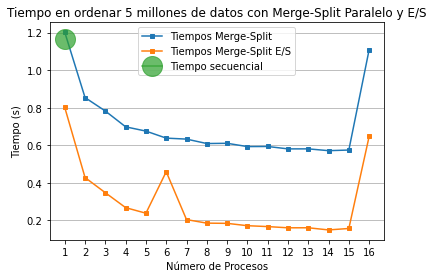

In [14]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 1.167692

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

tiempos_ms = np.array([1.2020037626,0.8539881506,0.7823763872,0.6982263885,0.6755205933,
                       0.6380895032,0.6328956983,0.6092411117,0.6105779088,0.5930719324,
                       0.5936499229,0.5808047755,0.5808634050,0.5713406708,0.5745974933,1.1089951680])

tiempos_ms_ES = np.array([0.8012046646,0.4280518945,0.3473020103,0.2678282503,0.2381900884,
                          0.4593050927,0.2041833270,0.1853683088,0.1841872241,0.1717050746,
                          0.1669840328,0.1605097670,0.1606462002,0.1492409855,0.1568408646,0.6469689608
])

fig, ax = plt.subplots()
ax.plot(procesos,tiempos_ms,marker='s',label='Tiempos Merge-Split',markersize=4)
ax.plot(procesos,tiempos_ms_ES,marker='s',label='Tiempos Merge-Split E/S',markersize=4)

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo en ordenar 5 millones de datos con Merge-Split Paralelo y E/S')

plt.legend()
plt.savefig('Tiempos_Merge_Split.png')
plt.show()

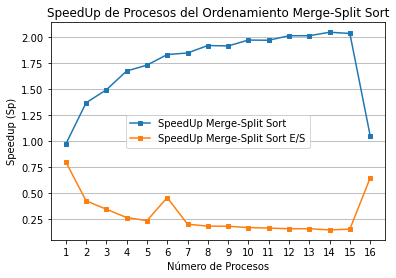

In [15]:
speedup_ms = tiempo_secuencial / tiempos_ms
speedup_ms_ES = tiempo_secuencial / tiempos_ms_ES

fig, ax = plt.subplots()

ax.plot(procesos,speedup_ms,marker='s',label='SpeedUp Merge-Split Sort',markersize=4)
ax.plot(procesos,tiempos_ms_ES,marker='s',label='SpeedUp Merge-Split Sort E/S',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos del Ordenamiento Merge-Split Sort')

plt.legend()
plt.savefig('SpeedUp_Merge_Split.png')
plt.show()

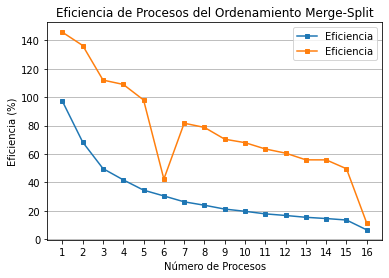

In [16]:
eficiencia_ms = speedup_ms / procesos * 100
eficiencia_ms_ES = speedup_ms_ES / procesos * 100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_ms,marker='s',label='Eficiencia',markersize=4)
ax.plot(procesos,eficiencia_ms_ES,marker='s',label='Eficiencia',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos del Ordenamiento Merge-Split')

plt.legend()
plt.savefig('Eficiencia_Merge_Split.png')
plt.show()

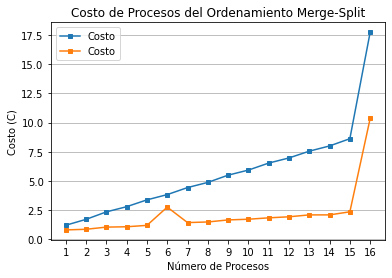

In [17]:
costo_ms = tiempos_ms * procesos
costo_ms_ES = tiempos_ms_ES * procesos


fig, ax = plt.subplots()

ax.plot(procesos,costo_ms,marker='s',label='Costo',markersize=4)
ax.plot(procesos,costo_ms_ES,marker='s',label='Costo',markersize=4)

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Costo (C)')
plt.title('Costo de Procesos del Ordenamiento Merge-Split')

plt.legend()
plt.savefig('Costo_Merge_Split.png')
plt.show()